In [1]:
import jax.numpy as jnp
import jax.random as jr
import diffrax
import matplotlib.pyplot as plt

In [2]:
seed = 1234
key = jr.key(seed)

## Jax tutorial: Ordinary differential equations with diffrax

We illustrate some functionalities of diffrax, the awesome ordinary differential equation solver from Patrick Kidger. Diffrax implements several common ODE solvers. It supports irregular time sampling, and it is fully differentiable and composable with all other JAX transformations.

We consider the Lotka-Volterra ordinary differential equation with state $x= [x_1\, x_2]^\top \in \mathbb{R}^{n_x}, n_x=2$:

\begin{align*}
\dot x_1  &= \alpha x - \beta x_1 x_2\\
\dot x_2  &= -\gamma x_2 + \delta x_1 x_2,
\end{align*}

with coefficients $\theta = [\alpha\, \beta\, \gamma\, \delta]^\top \in \mathbb{R}^{n_\theta}, n_{\theta} = 4$.

In [3]:
theta = jnp.array([0.1, 0.02, 0.4, 0.02])

In [4]:
def vector_field(t, x, args):
    prey, predator = x
    α, β, γ, δ = args
    d_prey = α * prey - β * prey * predator
    d_predator = -γ * predator + δ * prey * predator
    d_x = jnp.array([d_prey, d_predator])
    return d_x

In [5]:
# data
nx = 2  # number of states
seq_len = 20  # number of samples, sampling time is irregular

In [6]:
key, subkey = jr.split(key)
y0 = 8 * jr.uniform(subkey, (nx,)) + 6

t0 = 0
tf = 140
key, subkey = jr.split(key)
t_meas = jr.uniform(subkey, (seq_len,)) * (tf - t0) + t0 # irregular time sampling
t_meas = jnp.sort(t_meas)
t_meas = jnp.r_[0.0, t_meas] # add time 0 (nice for plots, not really needed)

t_dense = jnp.linspace(t0, tf, 1_000) # regular time sampling
dt0 = 1.0

In [7]:
def simulate(params, ts, y0):
    sol = diffrax.diffeqsolve(
        diffrax.ODETerm(vector_field),
        diffrax.Tsit5(), # Solver
        ts[0],
        ts[-1],
        dt0,
        y0,
        saveat=diffrax.SaveAt(ts=ts),
        args=params,
    )
    return sol.ys

In [8]:
y_sparse = simulate(theta, t_meas, y0)
y_dense = simulate(theta, t_dense, y0)

# just one sequence
t_meas = t_meas
y_sparse = y_sparse
y0 = y0
t_meas.shape, y0.shape, y_sparse.shape

((21,), (2,), (21, 2))

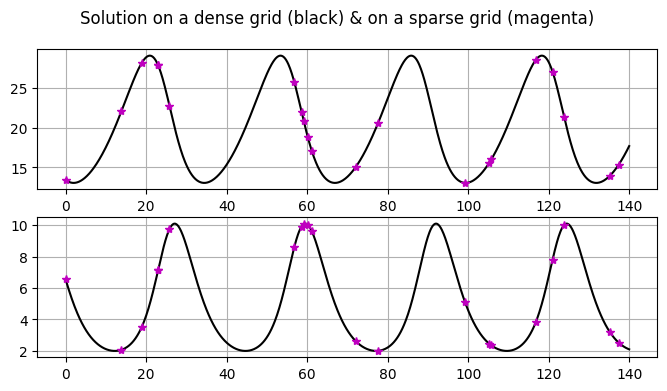

In [9]:
# plot data
fig, ax = plt.subplots(2, 1, figsize=(8, 4))
plt.suptitle("Solution on a dense grid (black) & on a sparse grid (magenta)")
ax[0].plot(t_dense, y_dense[:, 0], "k")
ax[0].plot(t_meas, y_sparse[:, 0], "m*")
ax[0].grid()

ax[1].plot(t_dense, y_dense[:, 1], "k")
ax[1].plot(t_meas, y_sparse[:, 1], "m*")
ax[1].grid()

See the probabilistic ode examples in the gallery for examples where we explore approximate Bayesian inference ODEs with [Laplace's method](gallery/ordinary_differential_equations/probabilistic_odes_laplace.ipynb) and [Markov Chain Monte Carlo](gallery/ordinary_differential_equations/probabilistic_odes_mcmc.ipynb)!

Note that we could use diffrax with a Neural-network vector field, and thus implement some fancy Neural ODEs!